In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import datetime
import os
import json
import numpy as np
import pandas as pd
import xarray as xr
import xmitgcm as xm
import socket
import scipy

In [2]:
from alplakes import parse_alplakes_3d_timeserie_from_directory, get_3d_profile_from_api, open_json, parse_json_3d_profile_to_df, parse_alplakes_1d_from_directory
from utils import save_json

### Parameters

In [3]:
lake_name = "Lake Neuchâtel"
sta_name = 'center_neuch'

model = 'test_zurich'

In [4]:
var_to_plot = 'THETA'

## Import cropped netcdf MITgcm results

In [9]:
file_config='mitgcm/config.json'
file_points='config_points.json'
with open(os.path.join(file_points), 'r') as file:
    config_points = json.load(file)[sta_name]
    
with open(file_config, 'r') as file:
        mitgcm_config = json.load(file)[socket.gethostname()][model]
config_points

{'lat_station_wgs84': 46.904,
 'long_station_wgs84': 6.843,
 'alplakes_1d_name': 'ctd_neuch',
 'xc_mitgcm_200m': 20755,
 'yc_mitgcm_200m': 5388}

In [10]:
ds = xm.open_mdsdataset(mitgcm_config['datapath'], ref_date=mitgcm_config['ref_date'], prefix='3Dsnaps', delta_t=mitgcm_config['dt'], endian=">")

xc_mitgcm_station = config_points['xc_mitgcm_200m']
yc_mitgcm_station = config_points['yc_mitgcm_200m']

i_xc = np.argmin(np.abs(ds['XC'].values - xc_mitgcm_station))
i_yc = np.argmin(np.abs(ds['YC'].values - yc_mitgcm_station))
i_xg = np.argmin(np.abs(ds['XG'].values - xc_mitgcm_station))
i_yg = np.argmin(np.abs(ds['YG'].values - yc_mitgcm_station))

ds_crop = ds[['THETA','UVEL','VVEL']].isel(XC=i_xc, YC=i_yc, XG=i_xg, YG=i_yg)

output_dir = "/storage/alplakes_test/Soren/lake_ne/run_2024_25/crop_output"
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, f"{sta_name}_cropped.nc")
ds_crop.to_netcdf(output_file)

print(f'Time series saved at: {output_file}')

Time series saved at: /storage/alplakes_test/Soren/lake_ne/run_2024_25/crop_output/center_neuch_cropped.nc


In [8]:
output_dir = "/storage/alplakes_test/Soren/lake_ne/run_2024_25/crop_output"
output_file = os.path.join(output_dir, f"{sta_name}_cropped.nc")
xr_mitgcm =  xr.open_dataset(output_file)
print(f'XC: {xr_mitgcm.XC.values}, YC: {xr_mitgcm.YC.values}')

XC: 3550.0, YC: 6450.0


In [9]:
mitgcm_paths = [r"output_dir\lexplore_depth_time_merged.nc"]
mitgcm_labels = "MITgcm results"

xr_mitgcm = []
for i in range(len(output_file)):
    xr_mitgcm.append(xr.open_dataset(mitgcm_paths[i]))

new_time= np.arange("2024-03-01T00:00:00", 
                              np.datetime64("2024-03-01T00:00:00") + np.timedelta64(len(xr_mitgcm[0].time.values), "h"), 
                              np.timedelta64(1, "h"), 
                              dtype="datetime64[ns]")

xr_mitgcm[0] = xr_mitgcm[0].assign_coords(time=new_time)

xr_mitgcm_merged = xr.concat([xr_mitgcm[0], xr_mitgcm[1]], dim='time')

## Import measure

In [10]:
start_date = pd.to_datetime(xr_mitgcm['time'].values[0]).to_pydatetime()  #datetime(2024, 1, 1, 0, 0, 0)
end_date = pd.to_datetime(xr_mitgcm['time'].values[-1]).to_pydatetime() #datetime(2025, 1, 1, 0, 0, 0)
start_date

datetime.datetime(2024, 3, 4, 1, 0)

####  import measurements in nc format, and convert it into xarray

xr_measure = xr.open_dataset(f'./data/datalakes/geneva_idronaut/2024.nc')

####  import measurements in csv format, and convert it into xarray

In [11]:
import pandas as pd
meas_path = f'/home/rasmusso@eawag.wroot.emp-eaw.ch/Documents/plot_results/data/alplakes_3d/{sta_name}/measurements/{sta_name}_data.csv'
df1 = pd.read_csv(meas_path, parse_dates=["time"])
#df1.set_index("timestamp", inplace=True)
#df1 = df1.sort_index()

#measurement_file2 = rf'data/alplakes_3d/{sta_name}/measurements/{sta_name}_data_end.csv' 
#df2 = pd.read_csv(measurement_file2, parse_dates=["timestamp"])
#df2.set_index("timestamp", inplace=True)
#df2 = df2.sort_index()

#df = pd.concat([df1, df2])
df1['time'] = pd.to_datetime(df1['time'], utc=True)
df1 = df1.drop_duplicates(subset='time', keep='first')
df1=df1[df1['temperature'] <= 35]
df1.set_index("time", inplace=True)
df1 = df1.sort_index()

xr_measure = df1.to_xarray()
#xr_measure = xr_measure.rename({'timestamp': 'time'})
xr_measure

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 259991)
Coordinates:
  * time         (time) object 2MB 1709251268000000000 ... 1730419177000000000
Data variables:
    temperature  (time) float64 2MB 7.5 7.5 7.5 7.4 7.5 ... 12.6 12.9 12.9 13.1

## Import 1D simstrat alplakes

In [21]:
# Folder containing the JSON files
folder_path = './data/alplakes_1d/geneva/'  # Update this to your specific folder path
simstrat_data = parse_alplakes_1d_from_directory(folder_path)

## Alplakes 3D

In [12]:
def load_alplakes_3d(station_name, depth):
    alplakes_directory = rf"data/alplakes_3d/{station_name}/timeseries_{depth}m"
    
    if os.path.exists(alplakes_directory):   
        df_alplakes = parse_alplakes_3d_timeserie_from_directory(alplakes_directory)

        xr_alplakes = xr.Dataset(
            {
                'temperature': (['time'], df_alplakes['temperature'])
            },
            coords={
                'time': df_alplakes['time']
            }
        )
        #print(xr_alplakes['time'])
        unique_values, unique_ind = np.unique(xr_alplakes['temperature'].values, return_index=True)
        
        return xr_alplakes.isel(time=np.sort(unique_ind))
    else:
        return None

## Resample timeseries

In [13]:
def interpolate_to_time_axis(xr_ds, time_axis, max_gap):
    interp_result = xr_ds.interp(time=time_axis)
    nearest_times = xr_ds.time.sel(time=time_axis, method="nearest")
    time_diff = abs(nearest_times - time_axis)
    interp_result = interp_result.where(time_diff.values <= max_gap, np.nan)
    
    return interp_result

In [14]:
def resample_all_timeseries(time_step, depth_plot, max_gap_allowed):    
    common_time_axis = pd.date_range(
        start=pd.Timestamp(xr_mitgcm.time.min().values).normalize(), 
        end=pd.Timestamp(xr_mitgcm.time.max().values), 
        freq=time_step
    )
    common_time_axis = pd.to_datetime(common_time_axis).tz_localize(None)
    meas_selected = xr_measure['temperature']
    print(meas_selected['time'])
    meas_selected['time'] = pd.to_datetime(meas_selected['time'].values).tz_localize(None)
    meas_interp = interpolate_to_time_axis(meas_selected, common_time_axis, max_gap_allowed)
    print('measures interpolated')
    
    #simstrat_selected = simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date))
    #simstrat_interp = interpolate_to_time_axis(simstrat_selected, common_time_axis, max_gap_allowed)
    
    #alplakes_selected = load_alplakes_3d(sta_name, depth_plot)['temperature']
    #alplakes_selected['time'] = pd.to_datetime(alplakes_selected['time'].values).tz_localize(None)
    #alplakes_selected = alplakes_selected.sortby('time')
    #print(alplakes_selected['time'])
    #alplakes_interp = interpolate_to_time_axis(alplakes_selected, common_time_axis, max_gap_allowed)
    #print('alplakes interpolated')
    mitgcm_interp = []
    
    mitgcm_selected=xr_mitgcm['THETA'].sel(Z=depth_plot, method='nearest')
    mitgcm_interp_time = interpolate_to_time_axis(mitgcm_selected, common_time_axis, max_gap_allowed)
    mitgcm_interp.append(mitgcm_interp_time)
    print('mitgcm results interpolated')
    return meas_interp, mitgcm_interp#, alplakes_interp,simstrat_interp

## Compute RMSE

In [15]:
def compute_rmse(prediction, measures):
    return np.sqrt(np.nanmean((prediction - measures) ** 2))

In [16]:
def compute_rmse_all_timeseries(meas_interp, mitgcm_interp):#, alplakes_interp):#, simstrat_interp):
    #rmse_simstrat = compute_rmse(simstrat_interp.values, meas_interp.values) 
    #rmse_alplakes = compute_rmse(alplakes_interp.values, meas_interp.values)
    
    rmse_mitgcm = []
    for i in range(len(mitgcm_interp)):
        rmse_mitgcm.append(compute_rmse(mitgcm_interp[i].values, meas_interp.values))
        
    return rmse_mitgcm#, rmse_alplakes #, rmse_simstrat

## Plot timeserie

In [17]:
time_step = '3h'
depth_plot=-0 # Value should be negative !!
max_gap_allowed = np.timedelta64(3, 'h') 

meas_interp, mitgcm_interp = resample_all_timeseries(time_step, depth_plot, max_gap_allowed)

#matches the nan from delft3d to the measurements and mitgcm results
#mitgcm_interp[0] = mitgcm_interp[0].where(~np.isnan(alplakes_interp))
mitgcm_interp[0] = mitgcm_interp[0].where(~np.isnan(meas_interp))
#meas_interp = meas_interp.where(~np.isnan(alplakes_interp))
meas_interp = meas_interp.where(~np.isnan(mitgcm_interp[0]))
#alplakes_interp = alplakes_interp.where(~np.isnan(meas_interp))
#alplakes_interp = alplakes_interp.where(~np.isnan(mitgcm_interp[0]))

#calculates the rsme
rmse_mitgcm = compute_rmse_all_timeseries(meas_interp, mitgcm_interp)#,alplakes_interp)

<xarray.DataArray 'time' (time: 259991)> Size: 2MB
array([1709251268000000000, 1709251327000000000, 1709251388000000000, ...,
       1730419056000000000, 1730419116000000000, 1730419177000000000],
      dtype=object)
Coordinates:
  * time     (time) object 2MB 1709251268000000000 ... 1730419177000000000
measures interpolated
mitgcm results interpolated


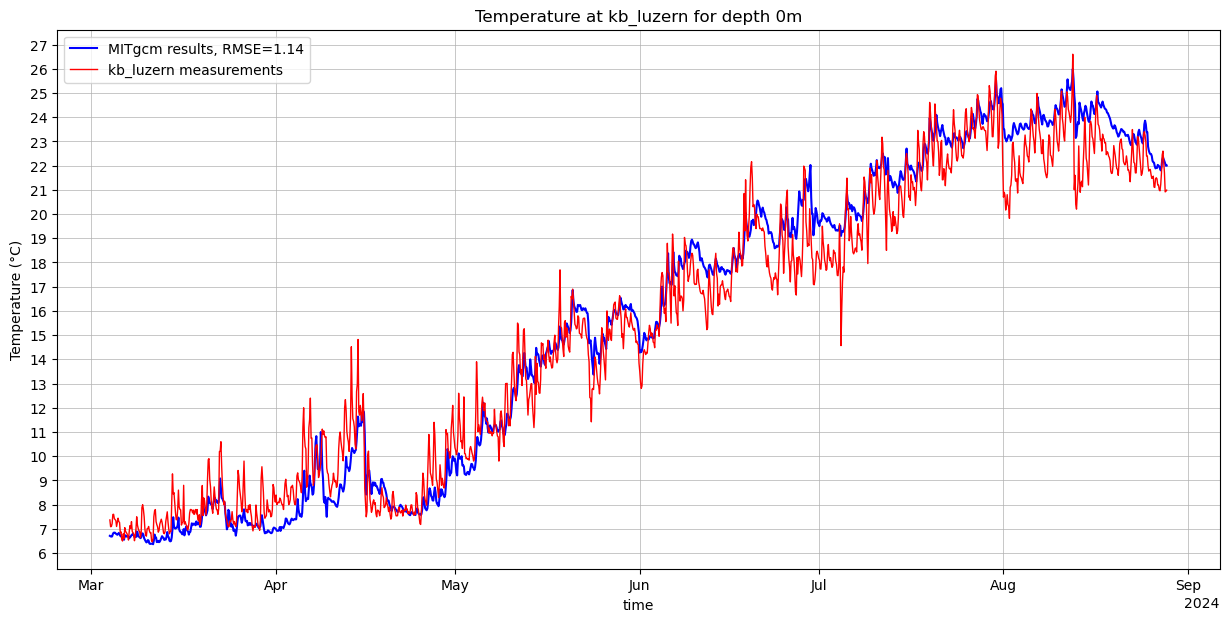

In [18]:
%matplotlib inline
plt.close('all')
fig, ax = plt.subplots(1,1,figsize=(15, 7))


mitgcm_interp[0].plot(label=f'{mitgcm_labels}, RMSE={rmse_mitgcm[0]:.2f}', color='b')
    
#simstrat_interp.plot(label=f'Simstrat 1D (from Alplakes), RMSE={rmse_simstrat:.2f}', color='g')
#alplakes_interp.plot(label=f'Delft3D (from Alplakes), RMSE={rmse_alplakes:.2f}', color='orange',linewidth=0.8)
meas_interp.plot(label=f'{sta_name} measurements', color='r', lw=1)

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel('Temperature (°C)')
plt.title(f"Temperature at {sta_name} for depth {depth_plot}m")

plt.savefig(rf"output_plots/RSME_{sta_name}_{depth_plot}m_100.png")
plt.show()

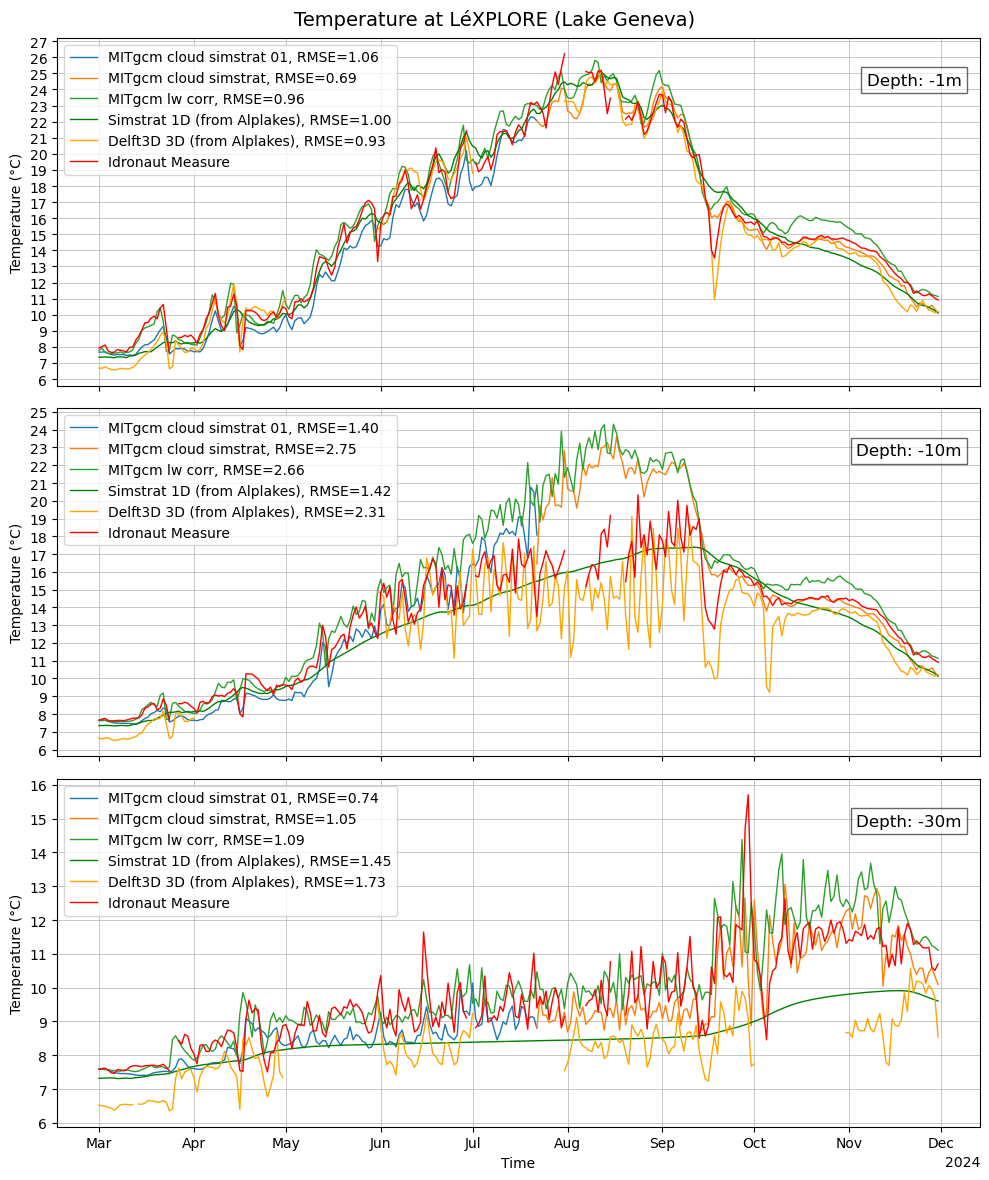

In [35]:
%matplotlib inline
# Flush old figures
plt.close('all')

# Define depths
depths = [-1, -10, -30]

# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
# Loop through subplots and depths
for i, depth_plot in enumerate(depths):
    ax = axes[i]
    
    meas_interp, simstrat_interp, alplakes_interp, mitgcm_interp = resample_all_timeseries(time_step, depth_plot, max_gap_allowed)
    rmse_mitgcm, rmse_simstrat, rmse_alplakes = compute_rmse_all_timeseries(meas_interp, mitgcm_interp, simstrat_interp, alplakes_interp)

    # Plot data
    for j in range(len(mitgcm_interp)):
        mitgcm_interp[j].resample(time='d').mean().plot(ax=ax, label=f'{mitgcm_labels[j]}, RMSE={rmse_mitgcm[j]:.2f}', lw=1)
        
    simstrat_interp.resample(time='d').mean().plot(ax=ax, label=f'Simstrat 1D (from Alplakes), RMSE={rmse_simstrat:.2f}', color='g', lw=1)
    alplakes_interp.resample(time='d').mean().plot(ax=ax, label=f'Delft3D 3D (from Alplakes), RMSE={rmse_alplakes:.2f}', color='orange', lw=1)
    meas_interp.resample(time='d').mean().plot(ax=ax, label=f'Idronaut Measure', color='r', lw=1)

    # Grid, axis formatting
    ax.grid(True, which='both', linestyle='-', linewidth=0.5)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.set_xlabel(None)
    ax.set_ylabel('Temperature (°C)')
    ax.set_title(None)  # Completely remove the title

    # Add depth as a subtitle inside the plot
    ax.text(
        0.98, 0.9, f'Depth: {depth_plot}m', 
        transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',  # Align text to the right
        bbox=dict(facecolor='white', alpha=0.6, edgecolor='black')
    )
    ax.legend() 

# Global title
fig.suptitle("Temperature at LéXPLORE (Lake Geneva)", fontsize=14)

plt.xlabel("Time")  # Add x-axis label
plt.tight_layout()  # Adjust layout
plt.show()

# Profile

In [37]:
def get_alplakes_profile(date_plot_profil_str):
    with open(os.path.join('./config_points.json'), 'r') as file:
        config_points = json.load(file)[sta_name]
    
    lat_station_wgs84 = config_points['lat_station_wgs84']
    long_station_wgs84 = config_points['long_station_wgs84']
    
    alplakes_profile_json_path = rf".\data\alplakes_3d\{sta_name}\profiles\profile_{sta_name}_{date_plot_profil_str}m.json"
    if not os.path.isfile(alplakes_profile_json_path):
        alplakes_profile_json = get_3d_profile_from_api(lake_name, date_plot_profil_str, lat_station_wgs84, long_station_wgs84)
        save_json(alplakes_profile_json, alplakes_profile_json_path)
    else:
        alplakes_profile_json = open_json(alplakes_profile_json_path)
    
    return parse_json_3d_profile_to_df(alplakes_profile_json)

In [38]:
date_plot_profil = datetime(2024,8,10,12,0,0)
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')

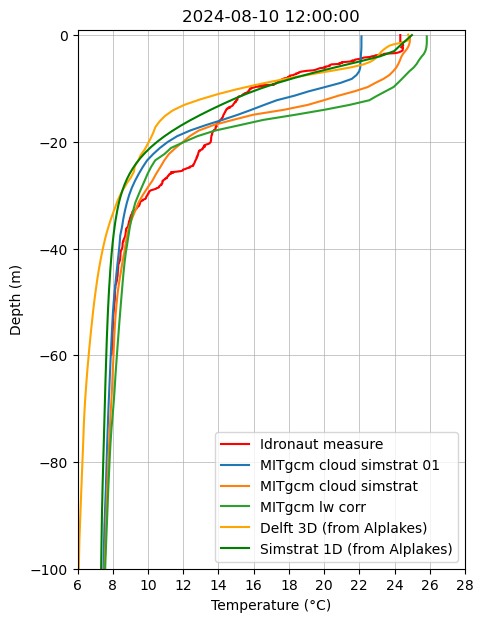

In [39]:
%matplotlib inline
plt.close()
fig, ax = plt.subplots(1,1,figsize=(5, 7))

meas_profile = xr_measure['temp'].sel(time=date_plot_profil, method='nearest')
plt.plot(meas_profile.values, meas_profile.depth.values, label=f'Idronaut measure', color='r')

for i in range(len(xr_mitgcm)):
    profile_mitgcm = xr_mitgcm[i][var_to_plot].sel(time=date_plot_profil, method='nearest')
    profile_mitgcm.where(profile_mitgcm != 0, np.nan).plot(y='Z', label=f'{mitgcm_labels[i]}')

alplakes_profile = get_alplakes_profile(date_plot_profil_str)
plt.plot(alplakes_profile['temperature'],-1*alplakes_profile['depth'], label=f'Delft 3D (from Alplakes)', color='orange')

# Convert Simstrat depth to negative and plot
simstrat_depth_negative = -simstrat_data['depth'].values  # Convert to negative NumPy array
simstrat_temperature = simstrat_data['temperature'].sel(time=date_plot_profil, method='nearest')
plt.plot(simstrat_temperature.values, simstrat_depth_negative, label='Simstrat 1D (from Alplakes)', color='g')

plt.title(f"{date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.ylim(bottom=-100, top=1)
plt.xlim(left=6, right=28)
plt.xlabel('Temperature (°C)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
plt.legend()
plt.show()
# plt.savefig(rf"output_plots\{lake_name}\profile_{date_plot_profil.date()}.png")